<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Building a DeepStream Application #
Now that we have established the fundamentals, we are ready to build a basic video AI application. DeepStream supports application development in C/C++ and in Python through [gst-python](https://gstreamer.freedesktop.org/modules/gst-python.html), the GStreamer framework’s Python bindings. To make it easier to get started, DeepStream ships withs several reference applications in both C/C++ and Python. These sample applications can be found in the [NVIDIA-AI-IOT](https://github.com/NVIDIA-AI-IOT/deepstream_reference_apps) GitHub page. For this lab, we'll be using Python. The other methods for development include: 
* Build application from source code
* Build application from command line
* Build application from a configuration file

**Note**: Separate [Python bindings](https://docs.nvidia.com/metropolis/deepstream/python-api/index.html) are included in the installation of the latest DeepStream SDK to enable DeepStream metadata access. 

## Learning Objectives ##
In this notebook, you will learn how to build a DeepStream pipeline using Python, including: 
* Planning the Pipeline Architecture
* Using Configuration File to Configure Deep Learning Inference
* Handling Metadata
* Measuring Pipeline Performance

**Table of Contents**
<br>
This notebook covers the below sections:  
1. [Planning the Video AI Application](#s1)
    * [Preview Input Video](#s1.1)
2. [Preparing the Deep Learning Model](#s2)
    * [TrafficCamNet Object Detection Model](#s2.1)
    * [Clustering](#s2.2)
    * [Installing NGC CLI](#s2.3)
3. [Building a Video AI Application - Part 1](#s3)
    * [Pipeline Components](#s3.1)
    * [Initializing GStreamer and Pipeline](#s3.2)
    * [Creating Pipeline Elements](#s3.3)
    * [Exercise #1 - Explore NvInfer Configuration File](#e1)
    * [Linking Pipeline Elements](#s3.4)
    * [Probe to Access Metadata](#s3.5)
    * [Starting the Pipeline](#s3.6)
    * [Analyzing Inference Results](#s3.7)
4. [Performance Analysis](#s4)
    * [Throughput with Modified Probe](#s4.1)
    * [Latency with Debug Log](#s4.2)
    * [GPU Utilization with NVIDIA System Management Interface](#s4.3)
5. [Building a Video AI Application - Part 2](#s5)
    * [Pipeline Components](#s5.1)
    * [Initializing GStreamer and Pipeline](#s5.2)
    * [Modifying Pipeline Elements](#s5.3)
    * [Linking Pipeline Elements](#s5.4)
    * [Modify Probe to Draw on Frames](#s5.5)
    * [Starting the Pipeline](#s5.6)
    * [Viewing Inference Results](#s5.7)
* [Troubleshooting](#s6)

<a name='s1'></a>
## Planning the Video AI Application ##
Building a video AI application begins by designing the project based on the use case. For this walk-through, we will build a simple DeepStream pipeline to accurately detect cars from a parking garage camera feed. This is the same pipeline as the sample application from the previous notebook. It includes several high-level steps: 
1. Read data from a video file
2. Perform deep learning inference on each frame
3. Perform post-processing with inference results
4. Write data to a file

<p><img src='images/steps.png' width=720></p>

We've strategically broken the entire pipeline into two parts to help with learning. 
* In part 1, we will build a simple DeepStream pipeline that will consume video data and perform inference on each frame for the purpose of counting the number of objects passing through in the video. 
* In part 2, we will add the ability to draw bounding boxes and text labels, as well write the output to a file, to our DeepStream pipeline. 

<a name='s1.1'></a>
### Preview Input Video ###
We begin by using the `ffprobe` command line utility to understand the raw input video's format ([see documentation if needed](https://ffmpeg.org/ffprobe.html)). When using the `ffprobe` command, the `-i` option lets us read an input [URL](https://en.wikipedia.org/wiki/URL) and the `-hide_banner` option suppresses printing the banner to reduce the output. 

In [1]:
# DO NOT CHANGE THIS CELL
import os

# Set the input video path to an environment variable
os.environ['TARGET_VIDEO_PATH']='data/sample_30.h264'
os.environ['TARGET_VIDEO_PATH_MP4']='sample_30.mp4'

target_video_path=os.environ['TARGET_VIDEO_PATH']
target_video_path_mp4=os.environ['TARGET_VIDEO_PATH_MP4']

# Analyze video
!ffprobe -i $TARGET_VIDEO_PATH \
         -hide_banner

Input #0, h264, from 'data/sample_30.h264':
  Duration: N/A, bitrate: N/A
    Stream #0:0: Video: h264 (High), yuv420p(progressive), 882x692, 30 fps, 30 tbr, 1200k tbn, 60 tbc


In the next step, we convert the video file into a container file before playing it since the H.264 encoded video file can't be played directly in JupyterLab. The [FFmpeg](https://ffmpeg.org/) tool is a very fast video and audio converter with the general syntax: 
* `ffmpeg [global_options] {[input_file_options] -i input_url} ... {[output_file_options] output_url} ...` 

When using the `ffmpeg` command, the `-i` option lets us read an input URL, the `-loglevel quiet` option suppresses the logs to reduce the output, and the `-y` flag overwrites any existing output file with the same name. 

In [ ]:
# DO NOT CHANGE THIS CELL
from IPython.display import Video

# Convert the H.264 encoded video file to MP4 container file - this will generate the sample_30.mp4 file
!ffmpeg -i $TARGET_VIDEO_PATH $TARGET_VIDEO_PATH_MP4 \
        -y \
        -loglevel quiet

# View the input video
Video(target_video_path_mp4, width=720)

<p><img src='images/important.png' width=720></p>

Please make note the **dimensions** of the video frames, **frame rate**, **codec**, **color model**, and **file format**. In this case, the file is compressed using the **H.264** codec. The video is made up of frames that are **882** pixels (width) by **692** pixels (height) using the **yuv420p** color encoding system at **30 FPS** (frames per second). 

<a name='s2'></a>
## Preparing the Deep Learning Model ##
For deep learning inference, we will use a pre-trained model that is available on [**N**VIDIA **G**PU **C**loud](https://ngc.nvidia.com/), the hub for GPU-optimized AI and high-performance computing (HPC) software. NGC offers pre-trained models for many AI tasks. We'll be using a purpose-built model from [NGC](https://catalog.ngc.nvidia.com/) called [TrafficCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/trafficcamnet). 

<a name='s2.1'></a>
### TrafficCamNet Object Detection Model ###
The TrafficCamNet Object Detection model, according to its [model card](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/trafficcamnet), detects one or more physical objects from four categories (car, persons, road signs, and two-wheelers) _within an image_ and returns a box around each object, as well as a category label for each object. 

For example, given an input image/frame, the inference engine will generate the bounding box coordinates as well as the category labels: 
<p><img src='images/sample_inference.png' width=720></p>

We can then _optionally_ perform post-processing and draw the bounding boxes and text labels on top of the original frame. 
<p><img src='images/sample_bounding_boxes.png' width=720></p>

<a name='s2.2'></a>
### Clustering ###
For object detection models, raw tensor data generated from the inference plugin need to be post-processed by a parsing and clustering algorithm to create bounding boxes around detected object. The data would be difficult and noisy to use otherwise. There are powerful clustering algorithms available in DeepStream, but you can customize your parsing algorithm inside the DeepStream app with the availability of tensor data. The size and dimension of the tensor data, as well as the parsing and clustering algorithm needed to parse the data, are dependent on the type of AI models. If you want to be able to bring customized models or new post-processing techniques to DeepStream, you’ll find it extremely useful to learn how to interact with the metadata. 
<p><img src='images/no_clustering.png'></p>

<a name='s2.3'></a>
### Installing NGC CLI ###
Pre-trained models can be downloaded from NGC using the [NGC CLI](https://ngc.nvidia.com/setup/installers/cli). We need to download and install the NGC CLI before using it. 

In [3]:
# DO NOT CHANGE THIS CELL
import os
os.environ['NGC_DIR']='/dli/task/ngc_assets'

# Download and install NGC CLI - this will create the ngc_assets folder
%env CLI=ngccli_linux.zip
!mkdir -p $NGC_DIR/ngccli
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $NGC_DIR/ngccli
!unzip -o \
       -u "$NGC_DIR/ngccli/$CLI" \
       -d $NGC_DIR/ngccli/
!rm $NGC_DIR/ngccli/*.zip
os.environ["PATH"]="{}/ngccli/ngc-cli:{}".format(os.getenv("NGC_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_linux.zip
--2024-11-25 20:57:01--  https://ngc.nvidia.com/downloads/ngccli_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 18.165.83.119, 18.165.83.111, 18.165.83.53, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|18.165.83.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47823313 (46M) [application/zip]
Saving to: ‘/dli/task/ngc_assets/ngccli/ngccli_linux.zip’

ngccli_linux.zip    100%[===================>]  45.61M   267MB/s    in 0.2s    

2024-11-25 20:57:02 (267 MB/s) - ‘/dli/task/ngc_assets/ngccli/ngccli_linux.zip’ saved [47823313/47823313]

Archive:  /dli/task/ngc_assets/ngccli/ngccli_linux.zip
   creating: /dli/task/ngc_assets/ngccli/ngc-cli/
   creating: /dli/task/ngc_assets/ngccli/ngc-cli/cryptography-42.0.8.dist-info/
  inflating: /dli/task/ngc_assets/ngccli/ngc-cli/cryptography-42.0.8.dist-info/LICENSE.APACHE  
  inflating: /dli/task/ngc_assets/ngccli/ngc-cli/cryptography-42.0.8.dist-info/METADATA  
 extracting: /dli/tas

To download a model from the registry, use the `ngc registry model download-version <org-name>/<model-name:version>` command and specify the model name as well as version. The model will be downloaded to a folder that corresponds to the model name in the current directory but can also be specified using the `-d` or `--dest` option. 

In [4]:
# DO NOT CHANGE THIS CELL
!ngc registry model download-version nvidia/tao/trafficcamnet:pruned_v1.0 --dest $NGC_DIR

Getting files to download...
⠋ ━━ • 0… • Remaining: … • ? • Elapsed: 0… • Total: 3 - Completed: 0 - Failed: 0
⠙ ━━ • 0… • Remaining: … • ? • Elapsed: 0… • Total: 3 - Completed: 0 - Failed: 0
⠹ ━━ • 0… • Remaining: … • ? • Elapsed: 0… • Total: 3 - Completed: 0 - Failed: 0
⠼ ━━ • 0… • Remaining: … • ? • Elapsed: 0… • Total: 3 - Completed: 0 - Failed: 0
⠴ ━━ • 0… • Remaining: … • ? • Elapsed: 0… • Total: 3 - Completed: 0 - Failed: 0
⠦ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 3 - Completed: 2 - Failed: 0
  ━━ • … • Remaining: 0… • … • Elapsed: 0… • Total: 3 - Completed: 3 - Failed: 0
       …                   …                                                    

-------------------------------------------------------------------------------
   Download status: COMPLETED
   Downloaded local path model: /dli/task/ngc_assets/trafficcamnet_vpruned_v1.0
   Total files downloaded: 3
   Total transferred: 5.2 MB
   Started at: 2024-11-25 20:59:32
   Completed at: 2024-11-25 20:59:33
  

<p><img src="images/check.png" width='720'></p>

Did you get the below error message? This is likely due to a bad NGC CLI configuration. Please check the _NGC CLI Configuration_ section of the [introduction notebook](00_introduction.ipynb). 

<a name='s3'></a>
## Building a Video AI Application - Part 1 ##
In part 1, we will build a simple DeepStream pipeline that consumes video data and performs inference on each frame for the purpose of counting the number of cars passing through in the video. 

<a name='s3.1'></a>
### Pipeline Components ###
This is the pipeline architecture of the application. We've selected each plugin based on their functionality. 
<p><img src="images/deepstream_pipeline_pt1.png" width='720'></p>

* The [filesrc](https://gstreamer.freedesktop.org/documentation/coreelements/filesrc.html) plugin reads data from a local file. There are other plugins available for reading data from various types of sources like camera, RTSP streams, and disk. 
* The [h264parse](https://gstreamer.freedesktop.org/documentation/videoparsersbad/h264parse.html) plugin is used to parse the input elementary H.264 stream into frame-size bytes of data. 
* The [nvv4l2decoder](https://gist.github.com/nins-k/6f7377629000894deedc7f14d7ef64fe) plugin decodes the input data using the appropriate codec, which is H.264 in this case.
* The [nvstreammux](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvstreammux.html) plugin is a required stream aggregator. This video aggregator helps in accepting `n` input streams and converts them into sequential batched frames. Even though our simple application only consumes one input stream, this plugin is required as `nvinfer` accepts _batched_ buffers with the `NvDsBatchMeta` structure already attached. 
    * This plugin takes `width`,  `height`, and `batch-size` as parameters. 
* The [nvinfer](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvinfer.html) plugin performs transformation (format conversion and scaling) on the input frame based on network requirements and passes the transformed data to the low-level library. This is the plugin that we will use to define the deep learning task(s) associated with our application. The low-level library pre-processes the transformed frames (performs normalization and mean subtraction) and produces final float RGB/BGR/GRAY planar data which are passed to the TensorRT engine for inferencing. The output type generated by the low-level library depends on the network type. We will configure the `nvinfer` plugin for our `TrafficCamNet` object detection model. It attaches the inference results such as _object class(s)_, _bounding box coordinates_, _etc._, to the metadata.
    * **Note**: Behaviour of inference is set through the config file. You can use the files provided below as a template or start the text file from scratch. 
    <p><img src="images/nvinfer.png" width='720'></p>
* The [fakesink](https://gstreamer.freedesktop.org/documentation/coreelements/fakesink.html) plugin acts as the end of the pipeline where the data flow ends. 
    * There is a synchronization-against-the-clock mechanism in GStreamer. For local video file, it is recommended to set the `sync` property to `1` to get smooth video playback, vs. `0` for live-sources such as IP camera since they give frames at a static rate. 

*More information about the plugins can be found in the [DeepStream Plugin Guide](https://docs.nvidia.com/metropolis/deepstream/dev-guide/index.html#plugins-development-guide) and [GStreamer Plugin Guide](https://gstreamer.freedesktop.org/documentation/plugins_doc.html).*

Additionally, we will add a **callback function** on the source pad of the `nvinfer` plugin to access the metadata in the application. The application can then use this metadata to solve the given problem (in this case counting the number of cars, persons, road signs, and two-wheelers).

<a name='s3.2'></a>
### Initializing GStreamer and Pipeline ###
We initialize GStreamer with `Gst.init(list=None)` and instantiate a `Gst.Pipeline` object as `pipeline` to contain all the elements shown in the pipeline diagram. 

In [5]:
# DO NOT CHANGE THIS CELL
# Import necessary GStreamer libraries and DeepStream python bindings
import gi
gi.require_version('Gst', '1.0')
from gi.repository import GObject, Gst, GLib
import pyds

# Initialize GStreamer
Gst.init(None)

# Create Pipeline element that will form a connection of other elements
pipeline=Gst.Pipeline()
print('Created pipeline')

Created pipeline


<a name='s3.3'></a>
### Creating Pipeline Elements ###
We create each element in the pipeline using `Gst.ElementFactory.make(factoryname, name)` (see [documentation](https://lazka.github.io/pgi-docs/Gst-1.0/classes/ElementFactory.html#Gst.ElementFactory.make)). We can configure elements using `set_property(property_name, value)` (see [documentation](https://gstreamer.freedesktop.org/documentation/plugin-development/basics/args.html?gi-language=c)) with the required parameters as needed. In this step, we also add the elements to the pipeline with `Gst.Pipeline.add(element)`. 

In [6]:
# DO NOT CHANGE THIS CELL
# Create Source element for reading from a file and set the location property
source=Gst.ElementFactory.make("filesrc", "file-source")
source.set_property('location', target_video_path)

# Create H264 Parser with h264parse as the input file is an elementary h264 stream
h264parser=Gst.ElementFactory.make("h264parse", "h264-parser")

# Create Decoder with nvv4l2decoder for accelerated decoding on GPU
decoder=Gst.ElementFactory.make("nvv4l2decoder", "nvv4l2-decoder")

# Create Streamux with nvstreammux to form batches for one or more sources and set properties
streammux=Gst.ElementFactory.make("nvstreammux", "stream-muxer")
streammux.set_property('width', 888) 
streammux.set_property('height', 696) 
streammux.set_property('batch-size', 1)

# Create Primary GStreamer Inference Element with nvinfer to run inference on the decoder's output after batching
pgie=Gst.ElementFactory.make("nvinfer", "primary-inference")

# Create Sink with fakesink as the end point of the pipeline
fakesink=Gst.ElementFactory.make('fakesink', 'fakesink')
fakesink.set_property('sync', 1)
print('Created elements')

Created elements


<p><img src='images/important.png' width=720></p>

Even though the source videos are **882** x **692**, the `nvstreammux` plugin wants to set the output dimensions to the nearest multiple of **8**, which is why we forced it to be **888** by **696**. This would otherwise be done automatically for us. The extra pixels will be padded black. We set the `batch-size` to be **1** frame per batch. It is _recommended_ that we set the `batch-size` to be equal to the number of input sources. 

In [7]:
# DO NOT CHANGE THIS CELL
# Add elements to pipeline
pipeline.add(source)
pipeline.add(h264parser)
pipeline.add(decoder)
pipeline.add(streammux)
pipeline.add(pgie)
pipeline.add(fakesink)
print('Added elements to pipeline')

Added elements to pipeline


<a name='e1'></a>
#### Exercise #1 - Explore Gst-nvinfer Configuration File ####
The `nvinfer` plugin needs to be configured through a [config file](./spec_files/pgie_config_trafficcamnet_03.txt)(`./spec_files/pgie_config_trafficcamnet_03.txt`), which has been completed for you. You can use this file as a _template_ or _start from scratch_. Please take a look to see how it's structured. 

These properties are important to understand: 
* Properties related to models downloaded from NGC or trained with the TAO Toolkit: 
    * `tlt-encoded-model` - pathname of the TAO Toolkit encoded model
    * `tlt-model-key` - model load key for the TAO Toolkit encoded model
    * `labelfile-path` - pathname of a text file containing the labels for the model. The labels must be new line delimited for object detection models
    * `uff-input-blob-name` - name of the input blob in the UFF file
    * `output-blob-names` - array of output layer names
    * `input-dims` - dimensions of the model input as [channel; height; width; input-order] where input-order=0 for NCHW
    * `net-scale-factor` - pixel normalization factor _(default=1)_

* Recommended properties: 
    * `batch-size` - number of frames to be inferred together in a batch _(default=1)_

* Mandatory properties for detectors: 
    * `num-detected-classes` - number of classes detected by the network

* Optional properties for detectors: 
    * `cluster-mode` - clustering algorithm to use _(default=0 i.e. Group Rectangles)_. Refer to the section on [clustering algorithms supported by nvinfer](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvinfer.html#cluster-mode-info) in the documentation for more information. 
    * `nms-iou-thresholds`: maximum IOU score between two proposals after which the proposal with the lower confidence will be rejected
    * `pre-cluster-thresholds`: detection threshold to be applied prior to clustering
    * `topk`: keep only top K objects with highest detection scores

* Other optional properties: 
    * `network-mode` - data format to be used for inference _(0=FP32, 1=INT8, 2=FP16 mode | default=0 i.e. FP32)_
    * `process-mode` - mode _(primary or secondary)_ in which the plugin is to operate on _(default=1 i.e. primary)_
    * `model-color-format` - color format required by the model _(default=0 i.e. RGB)_
    * `interval` - number of consecutive batches to be skipped for inference _(primary mode only | default=0)_
    * `gie-unique-id` - unique ID to be assigned to the GIE to enable the application and other elements to identify detected bounding boxes and labels _(default=0)_
    * `gpu-id` - device ID of GPU to use for pre-processing/inference _(dGPU only)_

You can find most of the information needed on the [model card](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/trafficcamnet): 

<p><img src='images/encryption_key.png' width=480></p>
<p><img src='images/model_card.png' width=720></p>

The blob names will be based on the deep learning model. For this pre-trained model from NGC, they can be found in the accompanied [text file](./ngc_assets/trafficcamnet_vpruned_v1.0/trafficnet_int8.txt) (`./ngc_assets/trafficcamnet_vpruned_v1.0/trafficnet_int8.txt`). 

<p><img src='images/blob_names.png' width=360></p>

In [8]:
# DO NOT CHANGE THIS CELL
!cat spec_files/pgie_config_trafficcamnet_03.txt

[property]
gpu-id=0
net-scale-factor=0.0039215697906911373
tlt-model-key=tlt_encode
tlt-encoded-model=/dli/task/ngc_assets/trafficcamnet_vpruned_v1.0/resnet18_trafficcamnet_pruned.etlt
labelfile-path=/dli/task/ngc_assets/trafficcamnet_vpruned_v1.0/labels.txt
input-dims=3;544;960;0
uff-input-blob-name=input_1
batch-size=1
process-mode=1
model-color-format=0
# 0=FP32, 1=INT8, 2=FP16 mode
network-mode=0
num-detected-classes=4
interval=0
gie-unique-id=1
output-blob-names=output_bbox/BiasAdd;output_cov/Sigmoid
cluster-mode=2

# Use the config params below for NMS clustering mode
[class-attrs-all]
topk=20
nms-iou-threshold=0.5
pre-cluster-threshold=0.2

**Note**: The values in the config file can be overridden by values set through `GObject` properties. Another important thing to remember is that the properties recommended are specific to a primary detector. You may need to configure other properties for secondary and/or classifier. 

After the configuration file has been created, we set the configuration file path of the `nvinfer` plugin using `set_property(property_name, value)`. 

In [9]:
# DO NOT CHANGE THIS CELL
# Set the configuration-file-path property for nvinfer
pgie.set_property('config-file-path', '/dli/task/spec_files/pgie_config_trafficcamnet_03.txt')

<a name='s3.4'></a>
### Linking Pipeline Elements ###
Finally, we link all these elements in the order that data flow through the pipeline with `Gst.Element.link(Gst.Element)`.
<p><img src='images/important.png' width=720></p>

When connecting a source to `nvstreammux` (the muxer), the input's source pad, obtained from `get_static_pad(name='src')`, must be manually linked to a newly requested sink pad from the muxer using `get_request_pad(name)` and the pad template `sink_%u`. This enables the ability to have multiple sources feeding into the `nvstreammux` plugin. 

In [10]:
# DO NOT CHANGE THIS CELL
# Link elements in the pipeline
source.link(h264parser)
h264parser.link(decoder)

# Link decoder source pad to streammux sink pad
decoder_srcpad=decoder.get_static_pad("src")    
streammux_sinkpad=streammux.get_request_pad("sink_0")
decoder_srcpad.link(streammux_sinkpad)

# Link the rest of the elements in the pipeline
streammux.link(pgie)
pgie.link(fakesink)
print('Linked elements in pipeline')

Linked elements in pipeline


<a name='s3.5'></a>
### Probe to Metadata Access ###
Recall that we use probes to access metadata, which are callback functions that interact with the pads of elements. To access the metadata, we can use the DeepStream Python bindings, `pyds`. DeepStream uses an extensible standard structure for metadata. The basic metadata structure `NvDsBatchMeta` starts with batch-level metadata, created inside the `Gst-nvstreammux` plugin (see below). The object-level metadata we are looking for is accessible through `NvDsBatchMeta` > `NvDsFrameMeta` > `NvDsObjectMeta`. Some metadata instances are stored in `GList` form, which requires the data to be casted to the appropriate structure using `pyds.NvDsFrameMeta.cast(data)` or  `pyds.NvDsObjectMeta.cast(data)`. The `NvDsObjectMeta` contains the inference results from the deep learning neural networks, depending on what the configurations are. 
<p><img src='images/DS_plugin_metadata.png' width=480></p>

We write the user-defined callback function `pgie_source_pad_buffer_probe`. Inside the function, we first get the batch metadata from the buffer with `pyds.gst_buffer_get_nvds_batch_meta(buffer)`. From there, we can iterate through all the metadata types that are attached to the buffer. The DeepStream plugins attach metadata of type `NVDS_META_FRAME_INFO` to the buffer. To achieve our goal, we access the object metadata to count the number of objects in each frame and print the bounding box coordindates. In this example we are using a 4-class-detectors (vehicle, person, two-wheeler, and road sign). The return value of the probe function is programmed to `Gst.PadProbeReturn.OK`, which is the normal probe return value and leaves the probe in place. There are other options for the [return value](https://lazka.github.io/pgi-docs/Gst-1.0/enums.html#Gst.PadProbeReturn) that can be considered for more complex cases. 

In [11]:
# DO NOT CHANGE THIS CELL
# Declare list to hold count data
obj_counts=[]

# Define the Probe Function
def pgie_src_pad_buffer_probe(pad, info):
    gst_buffer=info.get_buffer()

    # Retrieve batch metadata from the gst_buffer
    # Note that pyds.gst_buffer_get_nvds_batch_meta() expects the
    # C address of gst_buffer as input, which is obtained with hash(gst_buffer)
    batch_meta=pyds.gst_buffer_get_nvds_batch_meta(hash(gst_buffer))
    l_frame=batch_meta.frame_meta_list
    
    # Iterate through each frame in the batch metadata until the end
    while l_frame is not None:
        try:
            frame_meta=pyds.NvDsFrameMeta.cast(l_frame.data)
        except StopIteration:
            break

        frame_num=frame_meta.frame_num
        num_obj=frame_meta.num_obj_meta
        l_obj=frame_meta.obj_meta_list
        
        print("Frame Number={} Number of Objects={}".format(frame_num, num_obj))
        
        # Append number of objects a list 
        obj_counts.append(num_obj)
        
        # Iterate through each object in the frame metadata until the end
        while l_obj is not None:
            try:
                obj_meta=pyds.NvDsObjectMeta.cast(l_obj.data)
                print('\t Object: {} - Top: {}, Left: {}, Width: {}, Height: {}'.format(obj_meta.obj_label, \
                                                                                        round(obj_meta.rect_params.top), \
                                                                                        round(obj_meta.rect_params.left), \
                                                                                        round(obj_meta.rect_params.width), \
                                                                                        round(obj_meta.rect_params.height)))
            except StopIteration:
                break
            
            try: 
                l_obj=l_obj.next
            except StopIteration:
                break
        
        try:
            l_frame=l_frame.next
        except StopIteration:
            break
    return Gst.PadProbeReturn.OK

With the pipeline defined and the elements linked, we add the callback function on the source pad of the `nvinfer` plugin using `Gst.Pad.add_probe(mask, callback)`. While attached, the probe notifies when there are data passing on a pad. We can use `GST_PAD_PROBE_TYPE_BUFFER` or `GST_PAD_PROBE_TYPE_BUFFER_LIST` for `mask` when creating the probe. We designed the callback function to work with a single buffer so we're using `Gst.PadProbeType.BUFFER`. 

In [12]:
# DO NOT CHANGE THIS CELL
# Add probe to inference plugin's source
pgie_src_pad=pgie.get_static_pad('src')
probe_id=pgie_src_pad.add_probe(Gst.PadProbeType.BUFFER, pgie_src_pad_buffer_probe)
print('Attached probe')

Attached probe


<a name='s3.6'></a>
### Starting the Pipeline ###
The pipeline has a bus that we will use to monitor messages. We run a GLib/Gtk+ `MainLoop` (or iterate the default GLib main context regularly) and attach a watch/message handler to the bus with `Gst.Bus.add_signal_watch()`. This way the `GLib.Mainloop` will check the bus for new messages and notify. The message handler is also achieved through a callback function, which we define as `bus_call`. This handler will be called whenever the pipeline emits a message to the bus. The return value of the callback function should be `True` to keep it attached to the bus. Since this callback function for checking messages to the bus is used by many of the DeepStream applications, we refactor it into a [Python script](common/bus_call.py) (`./common/bus_call.py`) for ease of use. When we use `inpsect.getsource(object)` to look at the definition of the function, we find that it's a simple procedure that checks for the message type and handles them accordingly. With the message handler in place, we put the pipeline in the `PLAYING` state and run the `MainLoop`. Finally, when the pipeline is finished, we put the pipeline into the `NULL` state to clean up.

In [13]:
# DO NOT CHANGE THIS CELL
from common.bus_call import bus_call

# Inspect the definition for bus_call
from inspect import getsource
print(getsource(bus_call))

def bus_call(bus, message, loop):
    t = message.type
    if t == Gst.MessageType.EOS:
        sys.stdout.write("End-of-stream")
        loop.quit()
    elif t==Gst.MessageType.WARNING:
        err, debug = message.parse_warning()
        sys.stderr.write("Warning: %s: %s\n" % (err, debug))
    elif t == Gst.MessageType.ERROR:
        err, debug = message.parse_error()
        sys.stderr.write("Error: %s: %s\n" % (err, debug))
        loop.quit()
    return True



In [14]:
# DO NOT CHANGE THIS CELL
# Create an event loop
loop=GLib.MainLoop()

# Feed GStreamer bus messages to loop
bus=pipeline.get_bus()
bus.add_signal_watch()
bus.connect("message", bus_call, loop)
print('Added bus message handler')

Added bus message handler


In [15]:
# DO NOT CHANGE THIS CELL
# Start play back and listen to events
print("Starting pipeline")
pipeline.set_state(Gst.State.PLAYING)
try:
    loop.run()
except:
    pass

# Cleaning up as the pipeline comes to an end
pipeline.set_state(Gst.State.NULL)

Starting pipeline
Frame Number=0 Number of Objects=1
	 Object: car - Top: 26, Left: 366, Width: 59, Height: 37
Frame Number=1 Number of Objects=1
	 Object: car - Top: 26, Left: 366, Width: 60, Height: 37
Frame Number=2 Number of Objects=1
	 Object: car - Top: 26, Left: 366, Width: 60, Height: 37
Frame Number=3 Number of Objects=1
	 Object: car - Top: 26, Left: 367, Width: 62, Height: 41
Frame Number=4 Number of Objects=1
	 Object: car - Top: 26, Left: 367, Width: 62, Height: 41
Frame Number=5 Number of Objects=1
	 Object: car - Top: 26, Left: 367, Width: 63, Height: 41
Frame Number=6 Number of Objects=1
	 Object: car - Top: 28, Left: 369, Width: 65, Height: 40
Frame Number=7 Number of Objects=1
	 Object: car - Top: 28, Left: 368, Width: 66, Height: 41
Frame Number=8 Number of Objects=1
	 Object: car - Top: 28, Left: 369, Width: 66, Height: 40
Frame Number=9 Number of Objects=1
	 Object: car - Top: 29, Left: 369, Width: 74, Height: 50
Frame Number=10 Number of Objects=1
	 Object: car - 

<enum GST_STATE_CHANGE_SUCCESS of type Gst.StateChangeReturn>

<a name='s3.7'></a>
### Analyzing Inference Results ###
After the DeepStream pipeline completes the video processing, we summarize the inference results. 

<AxesSubplot:title={'center':'Object Count Over Time'}, xlabel='Frame Number'>

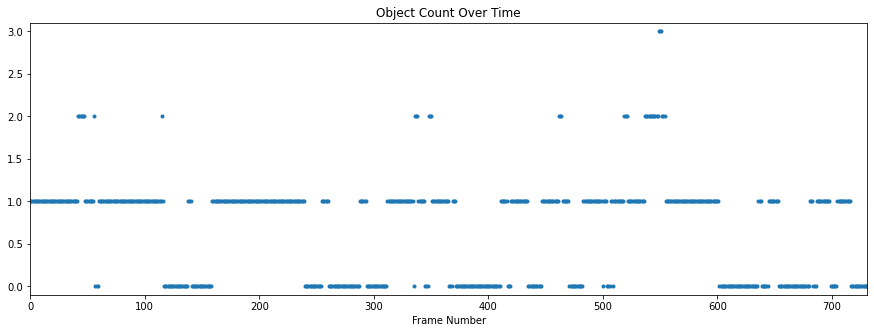

In [16]:
# DO NOT CHANGE THIS CELL
import pandas as pd

# Export data to a Pandas Series
obj_count_df=pd.Series(obj_counts, name='Object Count')
obj_count_df.index.name='Frame Number'

# Plot the Series
obj_count_df.plot(
    linestyle='none', 
    marker='.', 
    figsize=(15, 5), 
    ylim=[-.1, 3.1], 
    title='Object Count Over Time'
)

<p><img src='images/check.png' width=720></p>
Congratulations! You've built your first DeepStream pipeline. Before we add more functionality to this pipeline, let's look at how to evaluate its performance. 

<a name='s4'></a>
## Performance Analysis ##
In this section we will look at various metrics used to evaluate the performance of a DeepStream pipeline: 
* Throughput
* Latency
* Hardware Utilization

We refactor the code created so far into a [Python script](sample_apps/app_3_pt_1.py) (`./sample_apps/app_3_pt_1.py`) for ease of execution. This script can also be imported as a module to build the simple DeepStream pipeline using `building_simple_pipeline(input_source)`. More information can be found in the docstring. 

In [17]:
# DO NOT CHANGE THIS CELL
# Import app_3_pt_1.py from sample_apps directory
import sample_apps.app_3_pt_1

# Print the docstring 
print(sample_apps.app_3_pt_1.__doc__)


This python script can be used to detect objects in a H.264 video stream

Functions: 
    build_simple_pipeline: 
        Builds a simple pipeline with filesrc -> h264parse -> nvv4l2decoder -> nvstreammux -> nvinfer -> fakesink elements
        
    pgie_src_pad_buffer_probe: 
        Callback function that iterates through metadata and prints out the details of the objects detected
        
    main: 
        Main function that builds a pipeline with build_simple_pipeline, attaches the probe callback function to the nvinfer element, and starts the pipeline using input video URL as source



In [18]:
# DO NOT CHANGE THIS CELL
from sample_apps.app_3_pt_1 import build_simple_pipeline

# Print the docstring
print(build_simple_pipeline.__doc__)


    Builds a simple pipeline with filesrc -> h264parse -> nvv4l2decoder -> nvstreammux -> nvinfer -> fakesink elements

    Args: 
        input_source
    Returns: 
        pipeline
    


In [19]:
# DO NOT CHANGE THIS CELL
# Test run the Python script
!python sample_apps/app_3_pt_1.py data/sample_30.h264

Created Pipeline
Created elements
Added elements to pipeline
Linked elements in pipeline
Attached Probe
Added bus message handler
Starting pipeline
0:00:00.192690857   229      0x23da190 INFO                 nvinfer gstnvinfer.cpp:638:gst_nvinfer_logger:<primary-inference> NvDsInferContext[UID 1]: Info from NvDsInferContextImpl::buildModel() <nvdsinfer_context_impl.cpp:1914> [UID = 1]: Trying to create engine from model files
0:00:10.424673189   229      0x23da190 INFO                 nvinfer gstnvinfer.cpp:638:gst_nvinfer_logger:<primary-inference> NvDsInferContext[UID 1]: Info from NvDsInferContextImpl::buildModel() <nvdsinfer_context_impl.cpp:1947> [UID = 1]: serialize cuda engine to file: /dli/task/ngc_assets/trafficcamnet_vpruned_v1.0/resnet18_trafficcamnet_pruned.etlt_b1_gpu0_fp32.engine successfully
INFO: ../nvdsinfer/nvdsinfer_model_builder.cpp:610 [Implicit Engine Info]: layers num: 3
0   INPUT  kFLOAT input_1         3x544x960       
1   OUTPUT kFLOAT output_bbox/BiasAdd 16x3

<a name='s4.1'></a>
### Throughput with Modified Probe ###
**Throughput** is the amount of data that are processed in a specific amount of time. It can be interpreted as the average rate of successful data transmission in stream processing. The throughput for a DeepStream application should meet the requirements of the input video stream. We can measure throughput with a probe to get a sense of the dataflow and express it as frames per second (FPS). Below we create another probe function to measure the time it takes for frames to pass through the `nvinfer` plugin. By taking the [reciprocal](https://en.wikipedia.org/wiki/Reciprocal) of the time, we can approximate the frame rate. We're going to print out our frame rate for a single video stream, but we could expand this to generate metrics such as minimum, maximum, and average frame throughput at a granular level for each video stream. 

In [20]:
# DO NOT CHANGE THIS CELL
import time

frame_rates=[]

# Define the Probe Function
def pgie_src_pad_buffer_probe_fps(pad, info):
    global start
    frame_number=0
    gst_buffer=info.get_buffer()
    
    batch_meta=pyds.gst_buffer_get_nvds_batch_meta(hash(gst_buffer))
    l_frame=batch_meta.frame_meta_list
    
    # Iterate through each frame in the batch metadata until the end
    while l_frame is not None:
        now=time.time()
        try:
            frame_meta=pyds.NvDsFrameMeta.cast(l_frame.data)
        except StopIteration:
            break
        frame_number=frame_meta.frame_num
        
        # Take the reciprocal of the time difference as frame rate
        frame_rate=round(1/(now-start), 2)
        print('FPS: {} @ Frame {}.'.format(frame_rate, frame_number))
        
        # Add frame rate to frame_rates list
        frame_rates.append(frame_rate)
        
        try:
            l_frame=l_frame.next
        except StopIteration:
            break
        start=now
    return Gst.PadProbeReturn.OK

We use `build_simple_pipeline(input_source)` from the [app_3_pt_1.py](sample_apps/app_3_pt_1.py) script to build the simple pipeline and attach the new probe to the source pad of the `nvinfer` (primary-inference) plugin. We can use `Gst.Pipeline.get_by_name(name)` to reference an element within the existing pipeline. Afterwards we can start playback with `GLib.MainLoop` as we had done before. 

In [21]:
# DO NOT CHANGE THIS CELL
# Standard GStreamer initialization
Gst.init(None)

# Build pipeline
pipeline=build_simple_pipeline('data/sample_30.h264')
print('Successfully created a {} object'.format(type(pipeline)))

# Get the nvinfer plugin by name
pgie=pipeline.get_by_name('primary-inference')

# Add probe to inference plugin's source
pgie_src_pad=pgie.get_static_pad('src')
pgie_src_pad.add_probe(Gst.PadProbeType.BUFFER, pgie_src_pad_buffer_probe_fps)
print('Attached Probe')

Created Pipeline
Created elements
Added elements to pipeline
Linked elements in pipeline
Successfully created a <class 'gi.repository.Gst.Pipeline'> object
Attached Probe


In [22]:
# DO NOT CHANGE THIS CELL
# Create MainLoop and add a signal watch
loop=GLib.MainLoop()
bus=pipeline.get_bus()
bus.add_signal_watch()
bus.connect("message", bus_call, loop)
print('Added bus message handler')

Added bus message handler


In [23]:
# DO NOT CHANGE THIS CELL
# Start Pipeline
print("Starting pipeline")
pipeline.set_state(Gst.State.PLAYING)
start=time.time()
try:
    loop.run()
except:
    pass

# Cleaning up as the pipeline comes to an end
pipeline.set_state(Gst.State.NULL)

Starting pipeline
FPS: 8.74 @ Frame 0.
FPS: 378.65 @ Frame 1.
FPS: 31.3 @ Frame 2.
FPS: 30.05 @ Frame 3.
FPS: 29.95 @ Frame 4.
FPS: 30.08 @ Frame 5.
FPS: 30.01 @ Frame 6.
FPS: 29.94 @ Frame 7.
FPS: 30.02 @ Frame 8.
FPS: 30.02 @ Frame 9.
FPS: 30.02 @ Frame 10.
FPS: 30.02 @ Frame 11.
FPS: 30.04 @ Frame 12.
FPS: 29.94 @ Frame 13.
FPS: 30.0 @ Frame 14.
FPS: 29.96 @ Frame 15.
FPS: 29.95 @ Frame 16.
FPS: 30.04 @ Frame 17.
FPS: 30.08 @ Frame 18.
FPS: 29.93 @ Frame 19.
FPS: 30.01 @ Frame 20.
FPS: 29.95 @ Frame 21.
FPS: 29.95 @ Frame 22.
FPS: 30.13 @ Frame 23.
FPS: 30.01 @ Frame 24.
FPS: 29.96 @ Frame 25.
FPS: 30.0 @ Frame 26.
FPS: 30.04 @ Frame 27.
FPS: 29.89 @ Frame 28.
FPS: 30.04 @ Frame 29.
FPS: 30.06 @ Frame 30.
FPS: 29.97 @ Frame 31.
FPS: 29.97 @ Frame 32.
FPS: 30.05 @ Frame 33.
FPS: 30.03 @ Frame 34.
FPS: 29.99 @ Frame 35.
FPS: 29.91 @ Frame 36.
FPS: 30.09 @ Frame 37.
FPS: 29.92 @ Frame 38.
FPS: 30.11 @ Frame 39.
FPS: 29.93 @ Frame 40.
FPS: 30.04 @ Frame 41.
FPS: 29.88 @ Frame 42.
FPS: 3

<enum GST_STATE_CHANGE_SUCCESS of type Gst.StateChangeReturn>

After the DeepStream pipeline completes video processing, we summarize the throughput results. 

<AxesSubplot:title={'center':'Frame Rate Over Time'}, xlabel='Frame Number'>

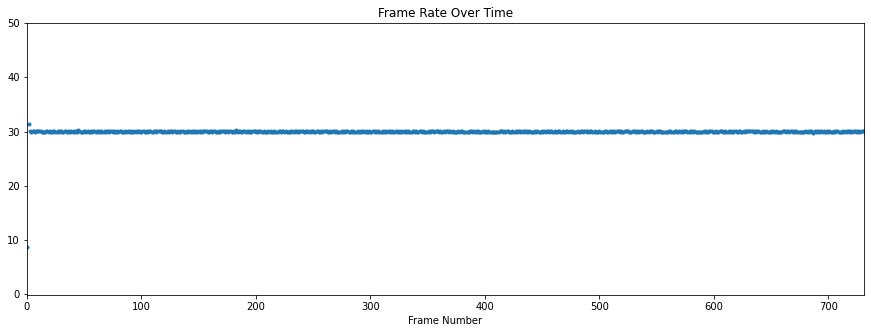

In [24]:
# DO NOT CHANGE THIS CELL
# Export data to a Pandas Series
frame_rates_df=pd.Series(frame_rates, name='Frame Rate')
frame_rates_df.index.name='Frame Number'

# Plot the Series
frame_rates_df.plot(
    linestyle='none', 
    marker='.', 
    figsize=(15, 5), 
    ylim=[-.1, 50], 
    title='Frame Rate Over Time')

<p><img src='images/check.png' width=720></p>
Based on the analysis, you can see that we are operating with a high frame rate that matches the required input video stream at 30 FPS (frames per second). Since the throughput can vary, analyzing the minimum, maximum, and average frame rates for your applications is highly recommended to understand any potentially unexpected performance issues.

<a name='s4.2'></a>
### Latency with Debug Log ###
**Latency** is the time difference between when data enter one element and into the next in the pipeline. In general, low latency is desirable and particularly important for real-time pipelines that are time-critical. In the context of video analytics, latency is the amount of time it takes for the input streams to be processed. Latency in a DeepStream pipeline can be measured using GStreamer debugging capabilities. The debug log is very useful but can be verbose. We specify the amount of desired output based on the below table (take from [GStreamer documentation](https://gstreamer.freedesktop.org/documentation/tutorials/basic/debugging-tools.html)). By setting the `GST-DEBUG` environment variable to `GST_SCHEDULING:7` when running the DeepStream pipeline, we get a `trace` log that contains details on when the buffers are processed. GStreamer allows for custom debugging information handlers, but the default one is very useful. When using the default handler, the content of each line in the debug output looks like the below and includes various information. 

In the next step, we run the pipeline using [app_3_pt_1.py](sample_apps/app_3_pt_1.py) and preview the first few lines of the output [trace.log](logs/trace.log) file. In order to make the log file useful, we parse the text and export the data into a dataframe. For demonstration, we have included a simple script to accomplish this. 

In [25]:
# DO NOT CHANGE THIS CELL
!GST_DEBUG='GST_SCHEDULING:7' GST_DEBUG_FILE='/dli/task/logs/trace.log' python sample_apps/app_3_pt_1.py data/sample_30.h264

Created Pipeline
Created elements
Added elements to pipeline
Linked elements in pipeline
Attached Probe
Added bus message handler
Starting pipeline
INFO: ../nvdsinfer/nvdsinfer_model_builder.cpp:610 [Implicit Engine Info]: layers num: 3
0   INPUT  kFLOAT input_1         3x544x960       
1   OUTPUT kFLOAT output_bbox/BiasAdd 16x34x60        
2   OUTPUT kFLOAT output_cov/Sigmoid 4x34x60         

Frame Number=0 Number of Objects=1
	 Object: car - Top: 26, Left: 366, Width: 59, Height: 37
Frame Number=1 Number of Objects=1
	 Object: car - Top: 26, Left: 366, Width: 60, Height: 37
Frame Number=2 Number of Objects=1
	 Object: car - Top: 26, Left: 366, Width: 60, Height: 37
Frame Number=3 Number of Objects=1
	 Object: car - Top: 26, Left: 367, Width: 62, Height: 41
Frame Number=4 Number of Objects=1
	 Object: car - Top: 26, Left: 367, Width: 62, Height: 41
Frame Number=5 Number of Objects=1
	 Object: car - Top: 26, Left: 367, Width: 63, Height: 41
Frame Number=6 Number of Objects=1
	 Object:

In [26]:
# DO NOT CHANGE THIS CELL
!head /dli/task/logs/trace.log

0:00:00.080959672   251      0x311ed00 LOG           GST_SCHEDULING gstpad.c:1445:gst_pad_add_probe:<primary-inference:src> adding probe for mask 0x00000010
0:00:00.080991935   251      0x311ed00 LOG           GST_SCHEDULING gstpad.c:1470:gst_pad_add_probe:<primary-inference:src> got probe id 1
0:00:00.180593865   251      0x311ed00 INFO                 nvinfer gstnvinfer.cpp:638:gst_nvinfer_logger:<primary-inference> NvDsInferContext[UID 1]: Info from NvDsInferContextImpl::buildModel() <nvdsinfer_context_impl.cpp:1914> [UID = 1]: Trying to create engine from model files
0:00:10.303917063   251      0x311ed00 INFO                 nvinfer gstnvinfer.cpp:638:gst_nvinfer_logger:<primary-inference> NvDsInferContext[UID 1]: Info from NvDsInferContextImpl::buildModel() <nvdsinfer_context_impl.cpp:1947> [UID = 1]: serialize cuda engine to file: /dli/task/ngc_assets/trafficcamnet_vpruned_v1.0/resnet18_trafficcamnet_pruned.etlt_b1_gpu0_fp32.engine successfully
0:00:10.310872619   251      0x311

In [27]:
# DO NOT CHANGE THIS CELL
# Import dependencies
import re

trace_log=[]
# Column headers per documentation
headers=['time_stamp', 'process_id', 'thread_id', 'level', 'category', 'src_file_line', 'function', 'object_name', 'message']

# Helper function to remove ANSI escape sequences
def escape_ansi(line):
    ansi_escape = re.compile(r'(?:\x1B[@-_]|[\x80-\x9F])[0-?]*[ -/]*[@-~]')
    return ansi_escape.sub('', line)

# Open trace.log
with open('/dli/task/logs/trace.log') as f: 
    # Read file
    lines=f.readlines()
    # Iterate through each line
    for each_line in lines: 
        # Exclude the last character, which is a newline (\n) character
        current_line=escape_ansi(each_line[:-1])
        # Split based on white space(s), keeping in mind that src_file, line, function, and object are concatenated together
        time_stamp, process_id, thread_id, level, category, src_file_line_function_object, message=re.split(' +', current_line, maxsplit=6)
        # Split src_file, line, function, and object based on the semicolon character
        src_file, line, function, object=src_file_line_function_object.split(':', maxsplit=3)
        # Add all data to the trace_log list
        trace_log.append([time_stamp, process_id, thread_id, level, category, f'{src_file}:{line}', function, object, message])

# Export data to a DataFrame
df=pd.DataFrame(trace_log, columns=headers)
# Preview the dataframe
df.head()

,time_stamp,process_id,thread_id,level,category,src_file_line,function,object_name,message
0,0:00:00.080959672,251,0x311ed00,LOG,GST_SCHEDULING,gstpad.c:1445,gst_pad_add_probe,<primary-inference:src>,adding probe for mask 0x00000010
1,0:00:00.080991935,251,0x311ed00,LOG,GST_SCHEDULING,gstpad.c:1470,gst_pad_add_probe,<primary-inference:src>,got probe id 1
2,0:00:00.180593865,251,0x311ed00,INFO,nvinfer,gstnvinfer.cpp:638,gst_nvinfer_logger,<primary-inference>,NvDsInferContext[UID 1]: Info from NvDsInferCo...
3,0:00:10.303917063,251,0x311ed00,INFO,nvinfer,gstnvinfer.cpp:638,gst_nvinfer_logger,<primary-inference>,NvDsInferContext[UID 1]: Info from NvDsInferCo...
4,0:00:10.310872619,251,0x311ed00,INFO,nvinfer,gstnvinfer_impl.cpp:313,notifyLoadModelStatus,<primary-inference>,[UID 1]: Load new model:/dli/task/spec_files/p...


Each line captures the time stamp of the message as well as the time stamp of the frame in the `message` column. For demonstration, we've included the below script to parse out the time stamp of the frames being processed from the `message` column. By examining the time stamp of the messages related to the same frame, we can see when each frame enters different elements in the pipeline. We can therefore derive the approximate latency by analyzing the time differences. For example, we can calculate the time difference between getting a message from `fakesink` and `nvinfer` to determine the amount of time it took for `nvinfer` to process the frame. 

In [28]:
# DO NOT CHANGE THIS CELL
# Iterate through rows backwards to get the time stamp
for idx, row in df[::-1].iterrows(): 
    # Time stamp is pts if object is a sink
    if row['object_name'] in ['<stream-muxer:sink_0>', '<primary-inference:sink>', '<fakesink:sink>']: 
        try: 
            df.loc[idx, 'frame_ts']=re.findall('pts \d+:\d+:\d+.\d+', row['message'])[0].split('pts ')[-1]
        except: 
            pass
    # Time stamp is dts if object is a decoder sink
    elif row['object_name']=='<nvv4l2-decoder:sink>': 
        try: 
            ts=re.findall('dts \d+:\d+:\d+.\d+', row['message'])[0].split('dts ')[-1]
            if ts: 
                df.loc[idx, 'frame_ts']=ts
                decoder_offset=re.findall('offset \d+', row['message'])[0].split('offset ')[-1]
        except: 
            pass
    # Time stamp is same as dts of decoder with same offset for file source
    elif row['object_name']=='<file-source:src>':
        try: 
            src_offset=re.findall('offset \d+', row['message'])[0].split('offset ')[-1]
            if src_offset==decoder_offset: 
                df.loc[idx, 'frame_ts']=ts
        except: 
            pass

In [29]:
# DO NOT CHANGE THIS CELL
time_df=df[['time_stamp', 'object_name', 'frame_ts']].dropna().drop_duplicates(subset=['object_name', 'frame_ts'])

# Pivot dataframe
time_df=time_df.pivot(index='object_name', values='time_stamp', columns='frame_ts')

# Leave time stamp as only seconds 
time_df.columns=[float(each_column.split(':')[2]) for each_column in time_df.columns]

# Display time_df
time_df=time_df.sort_values(0.0).applymap(lambda x: float(x.rsplit(':')[2]))
print('Time Stamp when Buffer Arrives (seconds)')
display(time_df) 

Time Stamp when Buffer Arrives (seconds)


,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,...,24.066666,24.100000,24.133333,24.166666,24.200000,24.233333,24.266666,24.300000,24.333333,24.366666
object_name,,,,,,,,,,,,,,,,,,,,,
<file-source:src>,10.311505,10.419185,10.419297,10.419360,10.419418,10.419592,10.425031,10.425703,10.426375,10.464507,...,34.231145,34.264546,34.264676,34.331168,34.364494,34.364890,34.431142,34.464442,34.464666,34.531127
<nvv4l2-decoder:sink>,10.312707,10.419226,10.419319,10.419379,10.419437,10.419628,10.425078,10.425748,10.426424,10.497788,...,34.231207,34.264593,34.264875,34.331235,34.364547,34.364929,34.431214,34.464486,34.464698,34.531166
<stream-muxer:sink_0>,10.419715,10.423344,10.424957,10.425921,10.426332,10.464615,10.498151,10.531573,10.564448,10.598305,...,34.364810,34.397742,34.431034,34.464634,34.497709,34.531034,34.564628,34.597762,34.631068,34.664516
<primary-inference:sink>,10.421690,10.424937,10.426211,10.426492,10.464379,10.497736,10.531047,10.564418,10.597750,10.631039,...,34.397705,34.430999,34.464336,34.497676,34.531014,34.564357,34.597743,34.631048,34.664409,34.697711
<fakesink:sink>,10.430591,10.436937,10.464739,10.498317,10.531555,10.564880,10.598427,10.631572,10.664926,10.698345,...,34.464581,34.497934,34.531294,34.564672,34.598156,34.631380,34.664668,34.698017,34.731259,34.764699


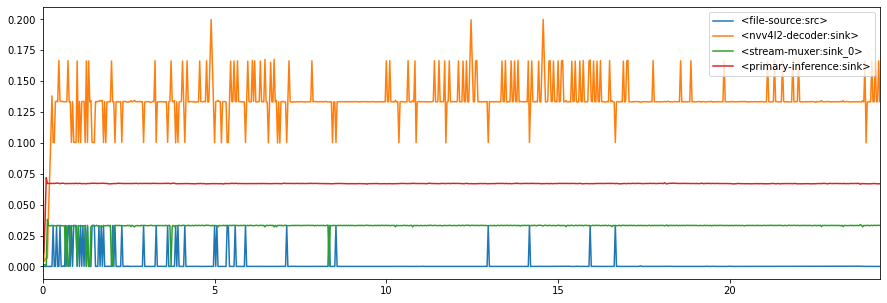

In [30]:
# DO NOT CHANGE THIS CELL
# Calculate time difference as processed time
diff_df=-time_df.diff(-1).T

# Plot results
diff_df.iloc[:, :-1].plot(figsize=(15, 5)).legend(loc='upper right')

<p><img src='images/check.png' width=720></p>
Based on the plot, you can see the average time it takes for one frame of data to pass through the different elements. While there could be some variance, the latency should be relatively consistent over time. With the trace log, you can identify if any of the plugins in the pipeline is running slowly. 

<a name='s4.3'></a>
### GPU Utilization with NVIDIA System Management Interface ###
**GPU utilization metrics** report how busy each GPU is over time and how much an application is using the GPUs in the system. We use `nvidia-smi` to explore the GPU utilization metrics while our application is running. We once again run [app_3_pt_1.py](sample_apps/app_3_pt_1.py) but this time while logging the results of `nvidia-smi`. We use the below options for `nvidia-smi`:
* `dmon -i 0`: reports default metrics (device monitoring) for the devices selected by comma-separated device list. We are reporting default metrics for GPU with index 0 since that is the only GPU we are using: 
* `-s ucmt`: select metrics to be displayed. In this case, we supplied ucmt to indicate we want metrics for. 
    * `u`: utilization (SM, memory, encoder, and decoder utilization in %)
    * `c`: proc and mem clocks (in MHz)
    * `m`: frame buffer and bar1 memory usage (in MB)
    * `t`: PCIe Rx and Tx throughput in MB/s (Maxwell and above)
* `-c 10`: configure monitoring iterations. It will display data for specified number of samples and exit. In this case, we choose 10 iterations.

In [31]:
# DO NOT CHANGE THIS CELL
!nvidia-smi dmon -i 0 \
                 -s ucmt \
                 -c 100 > '/dli/task/logs/smi.log' \
&python sample_apps/app_3_pt_1.py data/sample_30.h264

Created Pipeline
Created elements
Added elements to pipeline
Linked elements in pipeline
Attached Probe
Added bus message handler
Starting pipeline
0:00:00.183537551   271      0x21a7390 INFO                 nvinfer gstnvinfer.cpp:638:gst_nvinfer_logger:<primary-inference> NvDsInferContext[UID 1]: Info from NvDsInferContextImpl::buildModel() <nvdsinfer_context_impl.cpp:1914> [UID = 1]: Trying to create engine from model files
0:00:10.338941431   271      0x21a7390 INFO                 nvinfer gstnvinfer.cpp:638:gst_nvinfer_logger:<primary-inference> NvDsInferContext[UID 1]: Info from NvDsInferContextImpl::buildModel() <nvdsinfer_context_impl.cpp:1947> [UID = 1]: serialize cuda engine to file: /dli/task/ngc_assets/trafficcamnet_vpruned_v1.0/resnet18_trafficcamnet_pruned.etlt_b1_gpu0_fp32.engine successfully
INFO: ../nvdsinfer/nvdsinfer_model_builder.cpp:610 [Implicit Engine Info]: layers num: 3
0   INPUT  kFLOAT input_1         3x544x960       
1   OUTPUT kFLOAT output_bbox/BiasAdd 16x3

We can view the `smi.log` in the terminal or [separately](./logs/smi.log). The `sm` column tracks the percent of the time over the past sample period during which one or more kernels were executing on the GPU. Separately, the `fb` column reports the GPU's frame buffer memory usage. 

In [32]:
# DO NOT CHANGE THIS CELL
!cat /dli/task/logs/smi.log

# gpu    sm   mem   enc   dec  mclk  pclk    fb  bar1 rxpci txpci
# Idx     %     %     %     %   MHz   MHz    MB    MB  MB/s  MB/s
    0     0     0     0     0  5000   585   818     5     0     0
    0     5     0     0     0  5000   585  1141     7   287    37
    0    14     3     0     0  5000   585  1465     7   427    52
    0    61    49     0     0  5000  1500  1677     7    51     8
    0    43    20     0     0  5000  1590  1681     7   172    14
    0    38    13     0     0  5000  1590  1989     7   272    32
    0     5     1     0     0  5000  1305  1989     7     0     0
    0     0     0     0     0  5000   825  1989     7     1     0
    0     0     0     0     0  5000   585  1989     7     0     0
    0     0     0     0     0  5000   585  1989     7     0     0
    0     4     1     0     1  5000   585  1671     7    60     1
    0    21     4     0     2  5000   585  1671     7    13     9
    0    22     5     0     1  5000   585  1671     7     4    10
    0    2

<p><img src='images/check.png' width=720></p>

At a high level, applications should maintain a high utilization while not being at risk of exceeding the capacity. For those interested in learning more, comprehensive documentation can be accessed [here](http://developer.download.nvidia.com/compute/DCGM/docs/nvidia-smi-367.38.pdf). 

<a name='s5'></a>
## Building a Video AI Application - Part 2 ##
In part 2, we will add additional functionalities to the DeepStream pipeline to also create a composite video and write the output to a file. 

<a name='s5.1'></a>
### Pipeline Components ###
This is the pipeline architecture of the application. We've adding new plugins based on their functionality. 
<p><img src='images/deepstream_pipeline.png' width=720></p>

* The [filesrc](https://gstreamer.freedesktop.org/documentation/coreelements/filesrc.html) plugin will read data from a local file. There are other plugins available for reading data from various types of sources like camera, RTSP streams, and disk. 
* The [h264parse](https://gstreamer.freedesktop.org/documentation/videoparsersbad/h264parse.html) plugin is used to parse the input elementary H.264 stream into frame-size bytes of data. 
* The [nvv4l2decoder](https://gist.github.com/nins-k/6f7377629000894deedc7f14d7ef64fe) plugin will decode the input data using the appropriate codec, which is H.264 in this case.
* The [nvstreammux](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvstreammux.html) plugin is a required stream aggregator. This video aggregator helps in accepting `n` input streams and converts them into sequential batched frames. Even though our simple application only consumes one input stream, this plugin is required as `nvinfer` accepts _batched_ buffers with the `NvDsBatchMeta` structure already attached. 
    * This plugin takes `width`,  `height`, and `batch-size` as parameters. 
* The [nvinfer](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvinfer.html) plugin performs transformation (format conversion and scaling) on the input frame based on network requirements and passes the transformed data to the low-level library. This is the plugin that we will use to define the deep learning task(s) associated with our application. The low-level library pre-processes the transformed frames (performs normalization and mean subtraction) and produces final float RGB/BGR/GRAY planar data which are passed to the TensorRT engine for inferencing. The output type generated by the low-level library depends on the network type. We will configure the `nvinfer` plugin for our `TrafficCamNet` object detection model. It attaches the inference results such as _object class(s)_, _bounding box coordinates_, _etc._, to the metadata.
    * **Note**: Behaviour of inference is set through the config file. You can use the files provided below as a template or start the text file from scratch. 
* The [nvvideoconvert](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvvideoconvert.html) plugin converts frames from NV12 (YUV) to RGBA as required by `nvdsosd`. It is also capable of performing scaling, cropping, and rotating on the frames. 
* The [nvdsosd](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvdsosd.html) plugin draws bounding boxes and texts based on the metadata. It requires RGBA buffer as well as `NvDsBatchMeta`. 
* The [nvvideoconvert](https://docs.nvidia.com/metropolis/deepstream/dev-guide/text/DS_plugin_gst-nvvideoconvert.html) plugin converts frames from RGBA to I420 (YUV) as required by `avenc_mpeg4`. 
* The [capsfilter](https://gstreamer.freedesktop.org/documentation/coreelements/capsfilter.html) plugin does not modify data as such, but can enforce limitations on the data format. We use it to enforce the video conversion by `nvvideoconvert` to I420 (YUV) format. 
* The [avenc_mpeg4](https://gstreamer.freedesktop.org/documentation/libav/avenc_mpeg4.html) plugin encodes the I420 formatted frames using the MPEG4 codec. 
* The [filesink](https://gstreamer.freedesktop.org/documentation/coreelements/filesink.html) plugin writes incoming data to a file in the local file system. 

*More information about the plugins can be found in the [DeepStream Plugin Guide](https://docs.nvidia.com/metropolis/deepstream/dev-guide/index.html#plugins-development-guide) and [GStreamer Plugin Guide](https://gstreamer.freedesktop.org/documentation/plugins_doc.html).*

Additionally, we will add a **callback function** on the sink pad of the `nvdsosd` plugin to access the metadata in the application. The application can then use this metadata to solve the given problem (in this case draw the bounding boxes and texts).

<a name='s5.2'></a>
### Initializing GStreamer and Pipeline ###
To begin, we initialize GStreamer with `Gst.init(list=None)` and build a `Gst.Pipeline` object as `pipeline` using `build_simple_pipeline(input_source)`. We will modify the elements included in this pipeline. 

In [33]:
# DO NOT CHANGE THIS CELL
# Initialize GStreamer
Gst.init(None)

# Build pipeline
pipeline=build_simple_pipeline('data/sample_30.h264')
print('Successfully created a {} object'.format(type(pipeline)))

Created Pipeline
Created elements
Added elements to pipeline
Linked elements in pipeline
Successfully created a <class 'gi.repository.Gst.Pipeline'> object


<a name='s5.3'></a>
### Modifying Pipeline Elements ###
The simple pipeline created already includes `filesink` > `h264parse` > `nvv4l2decoder` > `nvstreammux` > `nvinfer` > `fakesink`. We modify this pipeline to suit our new use case. First, we _remove_ `fakesink` from the existing pipeline with `Gst.Pipeline.remove(element)`. Next, we create the `nvvideoconvert`, `nvdsosd`, another `nvvideoconvert`, `capsfilter`, `avenc_mpeg4`, and `filesink` elements using `Gst.ElementFactory.make(factoryname, name)` (see [documentation](https://lazka.github.io/pgi-docs/Gst-1.0/classes/ElementFactory.html#Gst.ElementFactory.make)). We can configure elements using `set_property(property_name, value)` (see [documentation](https://gstreamer.freedesktop.org/documentation/plugin-development/basics/args.html?gi-language=c)) with the required parameters as needed. Finally, we add the elements to the pipeline with `Gst.Pipeline.add(element)`. 

In [34]:
# DO NOT CHANGE THIS CELL
# Remove Fakesink
fakesink=pipeline.get_by_name('fakesink')
pipeline.remove(fakesink)

# Create Convertor to convert from YUV to RGBA as required by nvdsosd
nvvidconv1=Gst.ElementFactory.make("nvvideoconvert", "convertor1")

# Create OSD with nvdsosd to draw on the converted RGBA buffer
nvosd=Gst.ElementFactory.make("nvdsosd", "onscreendisplay")

# Create Convertor to convert from RGBA to I420 as required by encoder
nvvidconv2=Gst.ElementFactory.make("nvvideoconvert", "convertor2")

# Create Capsfilter to enforce frame image format
capsfilter=Gst.ElementFactory.make("capsfilter", "capsfilter")
caps=Gst.Caps.from_string("video/x-raw, format=I420")
capsfilter.set_property("caps", caps)

# Create Encoder to encode I420 formatted frames using the MPEG4 codec
encoder = Gst.ElementFactory.make("avenc_mpeg4", "encoder")
encoder.set_property("bitrate", 2000000)

# Create Sink and set the location for the output file
filesink=Gst.ElementFactory.make('filesink', 'filesink')
filesink.set_property('location', 'output_03_encoded.mpeg4')
filesink.set_property("sync", 1)
print('Created elements')

Created elements


In [35]:
# DO NOT CHANGE THIS CELL
# Add elements to pipeline
pipeline.add(nvvidconv1)
pipeline.add(nvosd)
pipeline.add(nvvidconv2)
pipeline.add(capsfilter)
pipeline.add(encoder)
pipeline.add(filesink)
print('Added elements to pipeline')

Added elements to pipeline


<a name='s5.4'></a>
### Linking Pipeline Elements ###
Finally, we link all these elements in the order that data flow through the pipeline with `Gst.Element.link(Gst.Element)`.

In [36]:
# DO NOT CHANGE THIS CELL
# Get the nvinfer plugin by name
pgie=pipeline.get_by_name('primary-inference')

# Link elements together
pgie.link(nvvidconv1)
nvvidconv1.link(nvosd)
nvosd.link(nvvidconv2)
nvvidconv2.link(capsfilter)
capsfilter.link(encoder)
encoder.link(filesink)
print('Linked elements in pipeline')

Linked elements in pipeline


<a name='s5.5'></a>
### Modify Probe to Draw on Frames ###
By the time the buffers reach the `nvdsosd` plugin, it will have the metadata it needs to draw bounding boxes and text labels for the detected objects on the frames. This means that a probe will not be needed if the default settings are sufficient. Based on specific use cases, we can use a probe to access and modify the metadata used by `nvdsosd` to draw, but it would have to be inserted at or before the `sink` pad of the `nvdsosd` plugin. To access the metadata, we can use the DeepStream Python bindings, `pyds`. There are generally two types of metadata we are interested in for drawing: 
* `NvDsObjectMeta.rect_params` and `NvDsObjectMeta.text_params` related to the objects detected or
* `NvDsBatchMeta` > `NvDsFrameMeta` > `NvDsDisplayMeta` related to overlays we want to add to each frame

There are a few similar parameters we can change for each but adding overlays to each frame requires some additional work. In order to acquire this display metadata, we use `pyds.nvds_acquire_display_meta_from_pool(batch_meta)` and set `num_labels`, `num_rects`, and `num_lines`. We can then assign values via `text_params`, `rect_params`, and `line_params`. The display metadata have to be added to the frame metadata with `pyds.nvds_add_display_meta_to_frame(frame_meta, display_meta)` for drawing. 

We write the user-defined callback function `osd_sink_pad_buffer_probe`. Inside the function, we iterate through all the metadata types that are attached to the buffer. We want to add a text label at the top of each frame and modify the border color of the bounding boxes. 

In [37]:
# DO NOT CHANGE THIS CELL
from random import random

# Define the Probe Function
def osd_sink_pad_buffer_probe(pad, info):
    gst_buffer=info.get_buffer()

    # Retrieve batch metadata from the gst_buffer
    # Note that pyds.gst_buffer_get_nvds_batch_meta() expects the
    # C address of gst_buffer as input, which is obtained with hash(gst_buffer)
    batch_meta=pyds.gst_buffer_get_nvds_batch_meta(hash(gst_buffer))
    l_frame=batch_meta.frame_meta_list

    # Iterate through each frame in the batch metadata until the end
    while l_frame is not None:
        try:
            frame_meta=pyds.NvDsFrameMeta.cast(l_frame.data)
        except StopIteration:
            break

        frame_number=frame_meta.frame_num
        num_rects=frame_meta.num_obj_meta
        l_obj=frame_meta.obj_meta_list
        
        # Iterate through each object in the frame metadata until the end
        while l_obj is not None:
            try:
                obj_meta=pyds.NvDsObjectMeta.cast(l_obj.data)
            except StopIteration:
                break
            
            # Set border color (red, green, blue, alpha) to random values
            obj_meta.rect_params.border_color.set(random(), random(), random(), random())
            
            try: 
                l_obj=l_obj.next
            except StopIteration:
                break

        # Acquire display metadata from pool and set number of labels to 1
        display_meta=pyds.nvds_acquire_display_meta_from_pool(batch_meta)
        display_meta.num_labels=1
        
        # Set text_params of the display metadata to local variable
        py_nvosd_text_params=display_meta.text_params[0]

        # Setting display text to be shown on screen
        py_nvosd_text_params.display_text="Frame Number={} Number of Objects={}".format(frame_number, num_rects)

        # Use pyds.get_string() to get display_text as string
        # Reading the display_text field here will return the C address of the
        # allocated string. Use pyds.get_string() to get the string content.
        print(pyds.get_string(py_nvosd_text_params.display_text))
        
        # Set the offsets where the string should appear
        py_nvosd_text_params.x_offset=10
        py_nvosd_text_params.y_offset=10

        # Set font, font-color (red, green, blue, alpha), and font-size
        py_nvosd_text_params.font_params.font_name="Serif"
        py_nvosd_text_params.font_params.font_size=15
        py_nvosd_text_params.font_params.font_color.set(1.0, 1.0, 1.0, 1.0)

        # Set text background color (red, green, blue, alpha)
        py_nvosd_text_params.set_bg_clr=1
        py_nvosd_text_params.text_bg_clr.set(0.0, 0.0, 0.0, 1.0)

        # Add to frame metadata
        pyds.nvds_add_display_meta_to_frame(frame_meta, display_meta)

        try:
            l_frame=l_frame.next
        except StopIteration:
            break
    return Gst.PadProbeReturn.OK

With the pipeline defined and the elements linked, we add the callback function on the sink pad of the `nvdsosd` plugin using `Gst.Pad.add_probe(mask, callback)`. While attached, the probe notifies when there are data passing on a pad. We can use `GST_PAD_PROBE_TYPE_BUFFER` or `GST_PAD_PROBE_TYPE_BUFFER_LIST` for `mask` when creating the probe. We designed the callback function to work with a single buffer so we're using `Gst.PadProbeType.BUFFER`. 

In [38]:
# DO NOT CHANGE THIS CELL
# Add probe to nvdsosd plugin's sink
osdsinkpad=nvosd.get_static_pad("sink")
probe_id=osdsinkpad.add_probe(Gst.PadProbeType.BUFFER, osd_sink_pad_buffer_probe)
print('Attached probe')

Attached probe


<a name='s5.6'></a>
### Starting the Pipeline ###
The pipeline has a bus that we will use to monitor messages. We run a GLib/Gtk+ `MainLoop` (or iterate the default GLib main context regularly) and attach a watch/message handler to the bus with `Gst.Bus.add_signal_watch()`. This way the `GLib.Mainloop` will check the bus for new messages and notify us. The message handler is also achieved through a callback function, which we define as `bus_call`. This handler will be called whenever the pipeline emits a message to the bus. The return value of the callback function should be `True` to keep it attached to the bus. Since this callback function for checking messages to the bus is used by many of the DeepStream applications, we refactor it into a [Python script](common/bus_call.py) (`./common/bus_call.py`) for ease of use. When we use `inpsect.getsource(object)` to look at the definition of the function, we find that it's a simple procedure that checks for the message type and handles them accordingly. With the message handler in place, we put the pipeline in the `PLAYING` state and run the `MainLoop`. Finally, when the pipeline is finished, we put the pipeline into the `NULL` state to clean up.

In [39]:
# DO NOT CHANGE THIS CELL
# Create an event loop
loop=GLib.MainLoop()

# Feed GStreamer bus messages to loop
bus=pipeline.get_bus()
bus.add_signal_watch()
bus.connect("message", bus_call, loop)
print('Added bus message handler')

Added bus message handler


In [40]:
# DO NOT CHANGE THIS CELL
# Start play back and listen to events - this will generate the output_03_raw.mpeg4 file
print("Starting pipeline")
pipeline.set_state(Gst.State.PLAYING)
try:
    loop.run()
except:
    pass

# Cleaning up as the pipeline comes to an end
pipeline.set_state(Gst.State.NULL)

Starting pipeline
Frame Number=0 Number of Objects=1
Frame Number=1 Number of Objects=1
Frame Number=2 Number of Objects=1
Frame Number=3 Number of Objects=1
Frame Number=4 Number of Objects=1
Frame Number=5 Number of Objects=1
Frame Number=6 Number of Objects=1
Frame Number=7 Number of Objects=1
Frame Number=8 Number of Objects=1
Frame Number=9 Number of Objects=1
Frame Number=10 Number of Objects=1
Frame Number=11 Number of Objects=1
Frame Number=12 Number of Objects=1
Frame Number=13 Number of Objects=1
Frame Number=14 Number of Objects=1
Frame Number=15 Number of Objects=1
Frame Number=16 Number of Objects=1
Frame Number=17 Number of Objects=1
Frame Number=18 Number of Objects=1
Frame Number=19 Number of Objects=1
Frame Number=20 Number of Objects=1
Frame Number=21 Number of Objects=1
Frame Number=22 Number of Objects=1
Frame Number=23 Number of Objects=1
Frame Number=24 Number of Objects=1
Frame Number=25 Number of Objects=1
Frame Number=26 Number of Objects=1
Frame Number=27 Numb

<enum GST_STATE_CHANGE_SUCCESS of type Gst.StateChangeReturn>

<a name='s5.7'></a>
### Viewing the Inference ###
In the next step, we convert the video file into a container file before playing it since the MPEG4 encoded video file can't be played directly in JupyterLab. The [FFmpeg](https://ffmpeg.org/) tool is a very fast video and audio converter with the general syntax: 
* `ffmpeg [global_options] {[input_file_options] -i input_url} ... {[output_file_options] output_url} ...` 

When using the `ffmpeg` command, the `-i` option lets us read an input URL, the `-loglevel quiet` option suppresses the logs to reduce the output, and the `-y` flag overwrites any existing output file with the same name. 

In [ ]:
# DO NOT CHANGE THIS CELL
# Convert MPEG4 video file to MP4 container file
!ffmpeg -i /dli/task/output_03_encoded.mpeg4 /dli/task/output_03.mp4 \
        -y \
        -loglevel quiet

# View the output video
Video("output_03.mp4", width=720)

<a name='s6'></a>
## Troubleshooting ##
Below are resolutions to some common issues. 
<p><img src='images/tip.png' width=720></p>

**Issue**: “NvDsBatchMeta not found for input buffer” error while running the DeepStream pipeline? 
<br>
**Solution**: The Gst-nvstreammux plugin is not in the pipeline. Starting with DeepStream 4.0, Gst-nvstreammux is a required plugin

**Issue**: The DeepStream application is running slowly.
<br>
**Solution**: When creating the `Gst-nvstreammux` plugin, set `width` and `height` to the stream’s resolution.

**Issue**: The DeepStream application doesn't run. 
<br>
**Solution**: Check the configuration file for `nvinfer`, particularly the `target_classes`. The list of classes must match what the networks has been trained for. The order of the list must be the same as that during training.

**Well Done!** When you're ready, let's move to the [next notebook](./04_building_a_MDNN_DeepStream_application.ipynb).

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>